In [1]:
import torch
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from monai.losses import DiceLoss
from monai.networks.nets import BasicUNet
from monai.transforms import (Compose, NormalizeIntensityd, RandCoarseDropoutd,
                              RandFlipd, RandGaussianNoised, ToTensorD,
                              RandScaleIntensityd, RandShiftIntensityd)

In [2]:
train_transform = Compose([
    NormalizeIntensityd(keys=["image"]),
    RandShiftIntensityd(keys="image", offsets=5, prob=0.5),
    RandGaussianNoised(keys="image", prob=0.9, std=1),
    RandScaleIntensityd(keys="image", factors=5, prob=0.5),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.5),
    RandCoarseDropoutd(keys="image", fill_value=0, holes=2, spatial_size=20, prob=0.5),
    ToTensorD(keys=["image", "label"]),
])

test_transform = Compose([
    NormalizeIntensityd(keys=["image"]),
    ToTensorD(keys=["image", "label"]),
])

class EMDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, mode='train', transform=None):
        self.data_dir = data_dir
        self.mode = mode
        self.img_dir = os.path.join(data_dir, mode, 'image')
        self.label_dir = os.path.join(data_dir, mode, 'label')
        self.img_list = os.listdir(self.img_dir)
        self.label_list = os.listdir(self.label_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        label_path = os.path.join(self.label_dir, self.label_list[idx])

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            data = self.transform({"image": np.array(img), "label": np.array(label)})
            img, label = data["image"], data["label"]
            img, label = img.unsqueeze(0), label.unsqueeze(0)

        return img, label == 0

train_dataset = EMDataset('challenge_files/', mode='train', transform=train_transform)
test_dataset = EMDataset('external_data/', mode='', transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

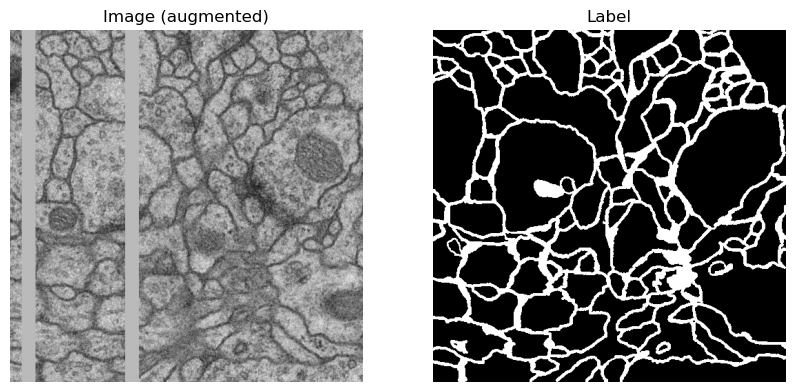

In [ ]:
img, label = train_dataset[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img[0], cmap='gray')
ax[0].set_title('Image (augmented)')
ax[0].axis('off')

ax[1].imshow(label[0], cmap='gray')
ax[1].set_title('Label')
ax[1].axis('off')

plt.show()

In [4]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.long().cuda()
        optimizer.zero_grad()
        loss = criterion(torch.softmax(model(inputs), dim=1), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.long().cuda()
            outputs = torch.softmax(model(inputs), dim=1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).unsqueeze(1)
            num = (labels == 1).sum().item() + (preds == 1).sum().item()
            correct = ((labels == 1) & (preds == 1)).sum().item()
            total_acc += 2 * correct / num
    return total_loss / len(test_loader), total_acc / len(test_loader)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BasicUNet(spatial_dims=2, in_channels=1, out_channels=2, features=(2, 4, 8, 16, 32, 64))
model.to(device)

criterion = DiceLoss(to_onehot_y=True, softmax=True)

lr = 1e-2
min_lr = 1e-6

optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=min_lr)

epochs = 100

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, test_loader, criterion)
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1:3d}/{epochs:3d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.1e}')


BasicUNet features: (2, 4, 8, 16, 32, 64).
Epoch   1/100, Train Loss: 0.5059, Val Loss: 0.4072, Val Acc: 0.6954, LR: 9.8e-03
Epoch   2/100, Train Loss: 0.4374, Val Loss: 0.3897, Val Acc: 0.6899, LR: 9.0e-03
Epoch   3/100, Train Loss: 0.4439, Val Loss: 0.3857, Val Acc: 0.6992, LR: 7.9e-03
Epoch   4/100, Train Loss: 0.4492, Val Loss: 0.3906, Val Acc: 0.6807, LR: 6.5e-03
Epoch   5/100, Train Loss: 0.4374, Val Loss: 0.3827, Val Acc: 0.7091, LR: 5.0e-03
Epoch   6/100, Train Loss: 0.4149, Val Loss: 0.3779, Val Acc: 0.7272, LR: 3.5e-03
Epoch   7/100, Train Loss: 0.4221, Val Loss: 0.3753, Val Acc: 0.7366, LR: 2.1e-03
Epoch   8/100, Train Loss: 0.4152, Val Loss: 0.3741, Val Acc: 0.7409, LR: 9.6e-04
Epoch   9/100, Train Loss: 0.4096, Val Loss: 0.3730, Val Acc: 0.7450, LR: 2.5e-04
Epoch  10/100, Train Loss: 0.3993, Val Loss: 0.3732, Val Acc: 0.7444, LR: 1.0e-02
Epoch  11/100, Train Loss: 0.4193, Val Loss: 0.3737, Val Acc: 0.7418, LR: 9.9e-03
Epoch  12/100, Train Loss: 0.4276, Val Loss: 0.3751, Va